In [15]:
library(data.table)
library(tidyverse)
library(ggplot2)
library(stringr)
library(zoo)
library(lubridate)
library(scales)
library(broom)
source("scripts/gamma_fit_utils.R")

In [16]:
# --------- 1. load the data set ---------
dtGeomagneticData <- data.table::fread(file = file.path("data", "GFZ_geomagnetic_data.csv"))
# set key
print(data.table::key(dtGeomagneticData))

NULL


In [17]:
# --------- 2. drop redundant columns columns ---------
print(colnames(dtGeomagneticData))
cColsToDrop <- c(
  "days_since_origin", "days_since_origin_threehourly_interval"
)
dtGeomagneticData <- dtGeomagneticData[, (cColsToDrop) := NULL]
print(colnames(dtGeomagneticData))

 [1] "date_year"                             
 [2] "date_month"                            
 [3] "date_day"                              
 [4] "which_threehourly_interval"            
 [5] "specific_observation_time"             
 [6] "days_since_origin_threehourly_interval"
 [7] "days_since_origin"                     
 [8] "Kp"                                    
 [9] "ap"                                    
[10] "is_definitive"                         
[1] "date_year"                  "date_month"                
[3] "date_day"                   "which_threehourly_interval"
[5] "specific_observation_time"  "Kp"                        
[7] "ap"                         "is_definitive"             


In [18]:
# --------- 3. prepare date column ---------
# 3.1. pad months and days with zeros
# print(lapply(X = dtGeomagneticData, FUN = typeof))
dtGeomagneticData[, date_month := stringr::str_pad(string = date_month, pad = "0", width = 2, side = "left")]
dtGeomagneticData[, date_day := stringr::str_pad(string = date_day, pad = "0", width = 2, side = "left")]
dtGeomagneticData[, date_year := as.character(date_year)]
# 3.2. concatenate date columns into a date string
dtGeomagneticData[, date_isodate := paste(date_year, date_month, date_day, sep = "-") %>%
                    as.Date(format = "%Y-%m-%d")]
# View(dtGeomagneticData)
# 3.3. drop redundant columns
cColsToDrop <- c("date_year", "date_month", "date_day")
dtGeomagneticData[, (cColsToDrop) := NULL]

   which_threehourly_interval specific_observation_time    Kp ap is_definitive
1:                          0                       1.5 1.667  6             1
2:                          3                       4.5 1.000  4             1
3:                          6                       7.5 0.667  3             1
4:                          9                      10.5 0.333  2             1
5:                         12                      13.5 1.667  6             1
6:                         15                      16.5 1.667  6             1
   date_isodate
1:   2012-01-01
2:   2012-01-01
3:   2012-01-01
4:   2012-01-01
5:   2012-01-01
6:   2012-01-01


In [20]:
View(head(dtGeomagneticData))

specific_observation_time,Kp,ap,is_definitive,date_isodate
<dbl>,<dbl>,<int>,<int>,<date>
1.5,1.667,6,1,2012-01-01
4.5,1.000,4,1,2012-01-01
7.5,0.667,3,1,2012-01-01
10.5,0.333,2,1,2012-01-01
13.5,1.667,6,1,2012-01-01
16.5,1.667,6,1,2012-01-01


In [19]:
# --------- 4. analyze obs times data ---------
table(dtGeomagneticData[, c("which_threehourly_interval", "specific_observation_time")])
# hence, column "which_threehourly_interval" can be dropped
dtGeomagneticData[, which_threehourly_interval := NULL]

                          specific_observation_time
which_threehourly_interval  1.5  4.5  7.5 10.5 13.5 16.5 19.5 22.5
                        0  3653    0    0    0    0    0    0    0
                        3     0 3653    0    0    0    0    0    0
                        6     0    0 3653    0    0    0    0    0
                        9     0    0    0 3653    0    0    0    0
                        12    0    0    0    0 3653    0    0    0
                        15    0    0    0    0    0 3653    0    0
                        18    0    0    0    0    0    0 3653    0
                        21    0    0    0    0    0    0    0 3653

In [21]:
# --------- 5. check if all observations are definitive ---------
# According to the description here: https://www-app3.gfz-potsdam.de/kp_index/Kp_ap_Ap_SN_F107_since_1932.txt
# any value of is_definitive column mean data is OK
table(dtGeomagneticData[, is_definitive])
print(nrow(dtGeomagneticData))
dtGeomagneticData <- dtGeomagneticData[dtGeomagneticData$is_definitive >= 1, ]
print(nrow(dtGeomagneticData))


    1     2 
26304  2920 

[1] 29224
[1] 29224


In [22]:
dtGeomagneticData[, quarter_date := zoo::as.yearqtr(date_isodate)]
dtSummaryStats <- dtGeomagneticData[
  , list(
    avg_Kp = mean(Kp), min_Kp = min(Kp), max_Kp = max(Kp),
    median_Kp = median(Kp),
    q_025_Kp = quantile(x = Kp, probs = 0.25),
    q_075_Kp = quantile(x = Kp, probs = 0.75),
    avg_ap = mean(ap), min_ap = min(ap), max_ap = max(ap),
    median_ap = median(ap),
    q_025_ap = quantile(x = ap, probs = 0.25),
    q_075_ap = quantile(x = ap, probs = 0.75)
  ),
  by = "quarter_date"
]
data.table::setkey(x = dtSummaryStats, "quarter_date")

In [24]:
View(head(dtSummaryStats))
View(tail(dtSummaryStats))

quarter_date,avg_Kp,min_Kp,max_Kp,median_Kp,q_025_Kp,q_075_Kp,avg_ap,min_ap,max_ap,median_ap,q_025_ap,q_075_ap
<yearqtr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
2012 Q1,1.911630,0,8.000,1.667,1.000,2.6670,10.652473,0,207,6,4,12.00
2012 Q2,1.740835,0,6.667,1.667,0.667,2.3330,9.094780,0,111,6,3,9.00
2012 Q3,1.807520,0,7.000,1.667,1.000,2.4165,9.656250,0,132,6,4,9.75
2012 Q4,1.237304,0,6.667,1.000,0.333,1.6670,6.826087,0,111,4,2,6.00
2013 Q1,1.454163,0,6.667,1.333,0.667,2.0000,7.363889,0,111,5,3,7.00
2013 Q2,1.720659,0,7.000,1.333,0.667,2.3330,9.248626,0,132,5,3,9.00


quarter_date,avg_Kp,min_Kp,max_Kp,median_Kp,q_025_Kp,q_075_Kp,avg_ap,min_ap,max_ap,median_ap,q_025_ap,q_075_ap
<yearqtr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
2020 Q3,1.269454,0,5.667,1.000,0.333,1.667,6.154891,0,67,4,2,6
2020 Q4,1.160304,0,4.667,1.000,0.333,1.667,5.191576,0,39,4,2,6
2021 Q1,1.569896,0,5.667,1.333,0.333,2.333,7.972222,0,67,5,2,9
2021 Q2,1.393288,0,7.000,1.000,0.667,2.000,6.804945,0,132,4,3,7
2021 Q3,1.379952,0,5.333,1.333,0.667,2.000,6.103261,0,56,5,3,7
2021 Q4,1.523086,0,7.667,1.333,0.667,2.333,7.843750,0,179,5,3,9


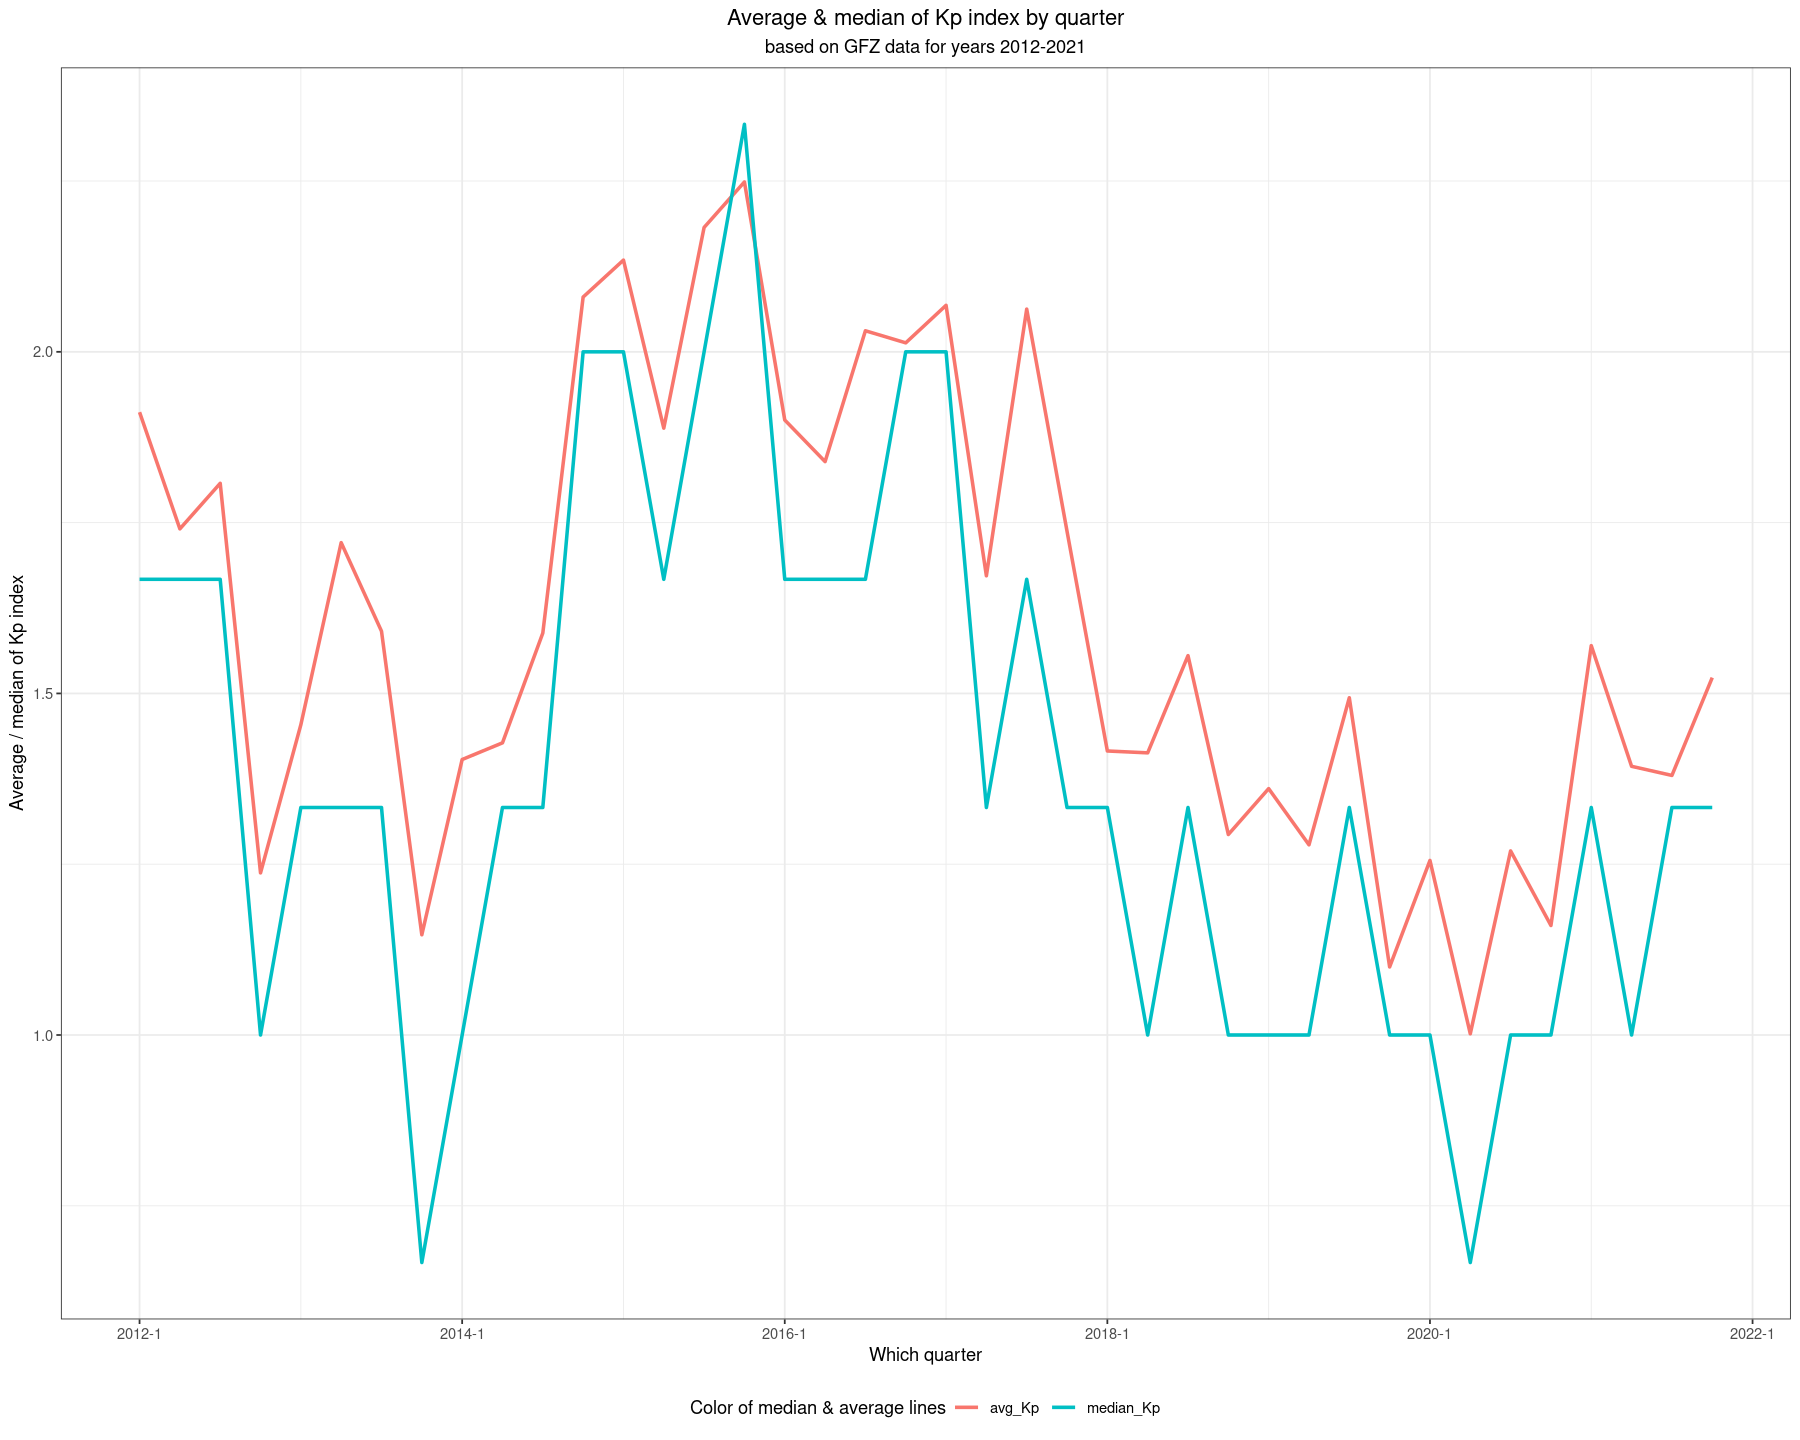

In [43]:
# --------- 7. plot average and median Kp over time ---------
options(repr.plot.width=15, repr.plot.height=12)
dtSummaryStatsPlot <- dtSummaryStats[, c("quarter_date", "avg_Kp", "median_Kp")]
dtSummaryStatsPlot <- data.table::melt.data.table(
  data = dtSummaryStatsPlot, id.vars = "quarter_date",
  measure.vars = c("avg_Kp", "median_Kp"),
  variable.name = "which_stat",
  value.name = "stat_value"
)
ggplot2::ggplot(data = dtSummaryStatsPlot) +
  ggplot2::geom_line(
    mapping = ggplot2::aes(x = quarter_date, y = stat_value, color = which_stat),
    size = 1
  ) +
  ggplot2::ggtitle(label = "Average & median of Kp index by quarter",
                   subtitle = "based on GFZ data for years 2012-2021") +
  ggplot2::xlab("Which quarter") +
  ggplot2::ylab("Average / median of Kp index") +
  ggplot2::theme_bw() +
  theme(
    plot.title = ggplot2::element_text(hjust = 0.5),
    plot.subtitle = ggplot2::element_text(hjust = 0.5),
    legend.position = "bottom"
  ) +
  ggplot2::scale_color_discrete(
    name = "Color of median & average lines"
  )

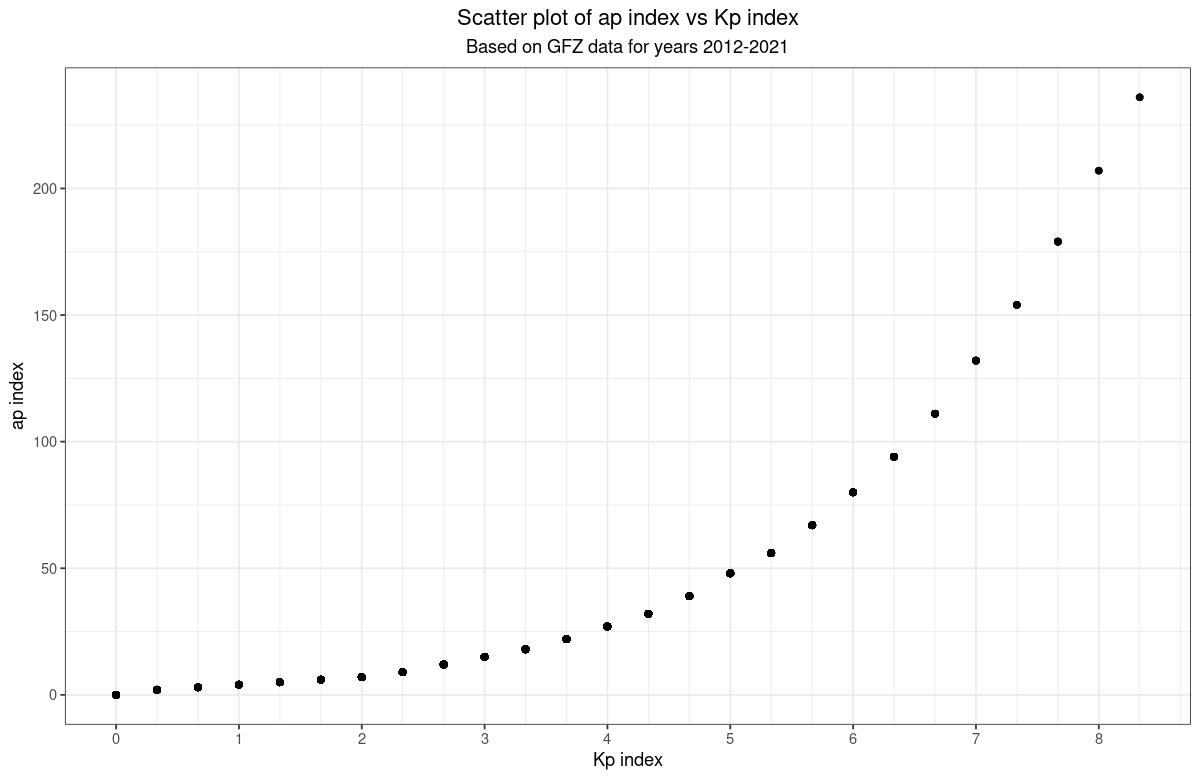

In [45]:
# --------- 8. scatter plot of ap against Kp index ---------
# Kp index is derived from ap using the rule described here: https://www.ngdc.noaa.gov/stp/GEOMAG/kp_ap.html
options(repr.plot.width=10, repr.plot.height=6.5)
ggplotIndicesScatterPlot <- ggplot2::ggplot(
  data = dtGeomagneticData, mapping = ggplot2::aes(x = Kp, y = ap)
) + ggplot2::geom_point() + ggplot2::theme_bw() + ggplot2::xlab("Kp index") + ggplot2::ylab("ap index") +
  ggplot2::ggtitle(label = "Scatter plot of ap index vs Kp index",
                   subtitle = "Based on GFZ data for years 2012-2021") +
  ggplot2::theme(plot.title = ggplot2::element_text(hjust = 0.5),
                 plot.subtitle = ggplot2::element_text(hjust = 0.5)) +
  ggplot2::scale_x_continuous(breaks = seq(0, 9, 1), minor_breaks = seq(0, 9, 1/3)) +
  ggplot2::scale_y_continuous(breaks = seq(0, 300, 50), minor_breaks = seq(0, 300, 25))
ggplotIndicesScatterPlot

In [27]:
# --------- 9. histogram of the Kp index ---------
ggplotKpRootHistogram <- ggplot2::ggplot(
  data = dtGeomagneticData, mapping = aes(x = Kp)
) + geom_histogram(
  bins = length(unique(dtGeomagneticData$Kp)),
  color = "black", fill = "red", alpha = 0.2
) + theme_bw() +
  scale_x_continuous(
    breaks = seq(0, 9, 1),
    minor_breaks = seq(0, 9, 1/3),
    labels = scales::label_number(accuracy = 0.01)
  )

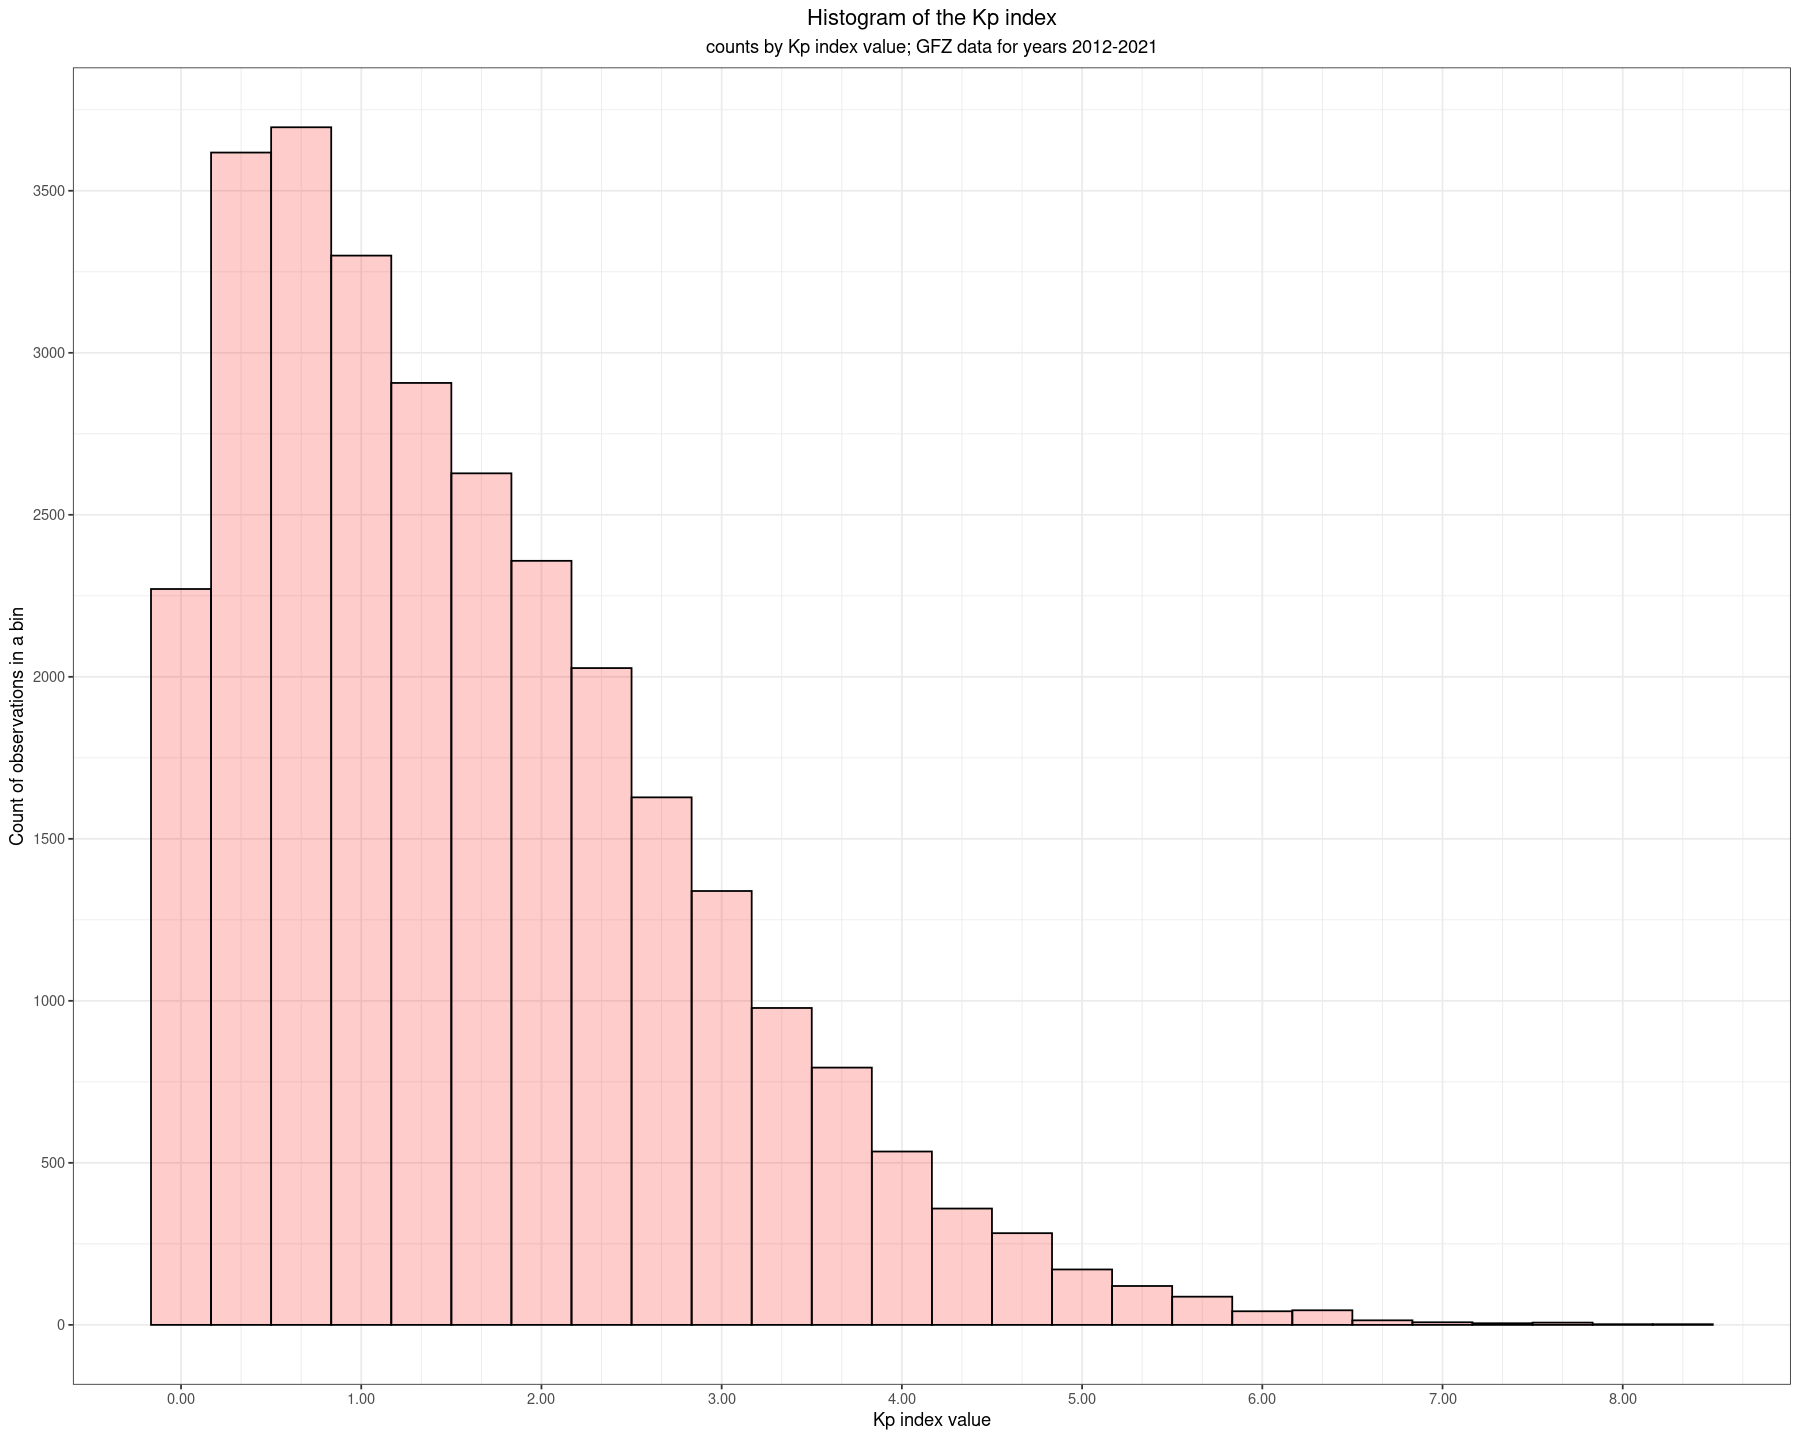

In [48]:
# 9.1. obs counts on the OY axis
options(repr.plot.width=15, repr.plot.height=12)
ggplotKpAbsHistogram <- ggplotKpRootHistogram + scale_y_continuous(
  breaks = seq(0, 4000, 500),
  minor_breaks = seq(0, 4000, 250)
) + ggtitle(label = "Histogram of the Kp index",
            subtitle = "counts by Kp index value; GFZ data for years 2012-2021") +
  theme(
    plot.title = element_text(hjust = 0.5),
    plot.subtitle = element_text(hjust = 0.5)
  ) + ylab(label = "Count of observations in a bin") +
  xlab(label = "Kp index value")
ggplotKpAbsHistogram

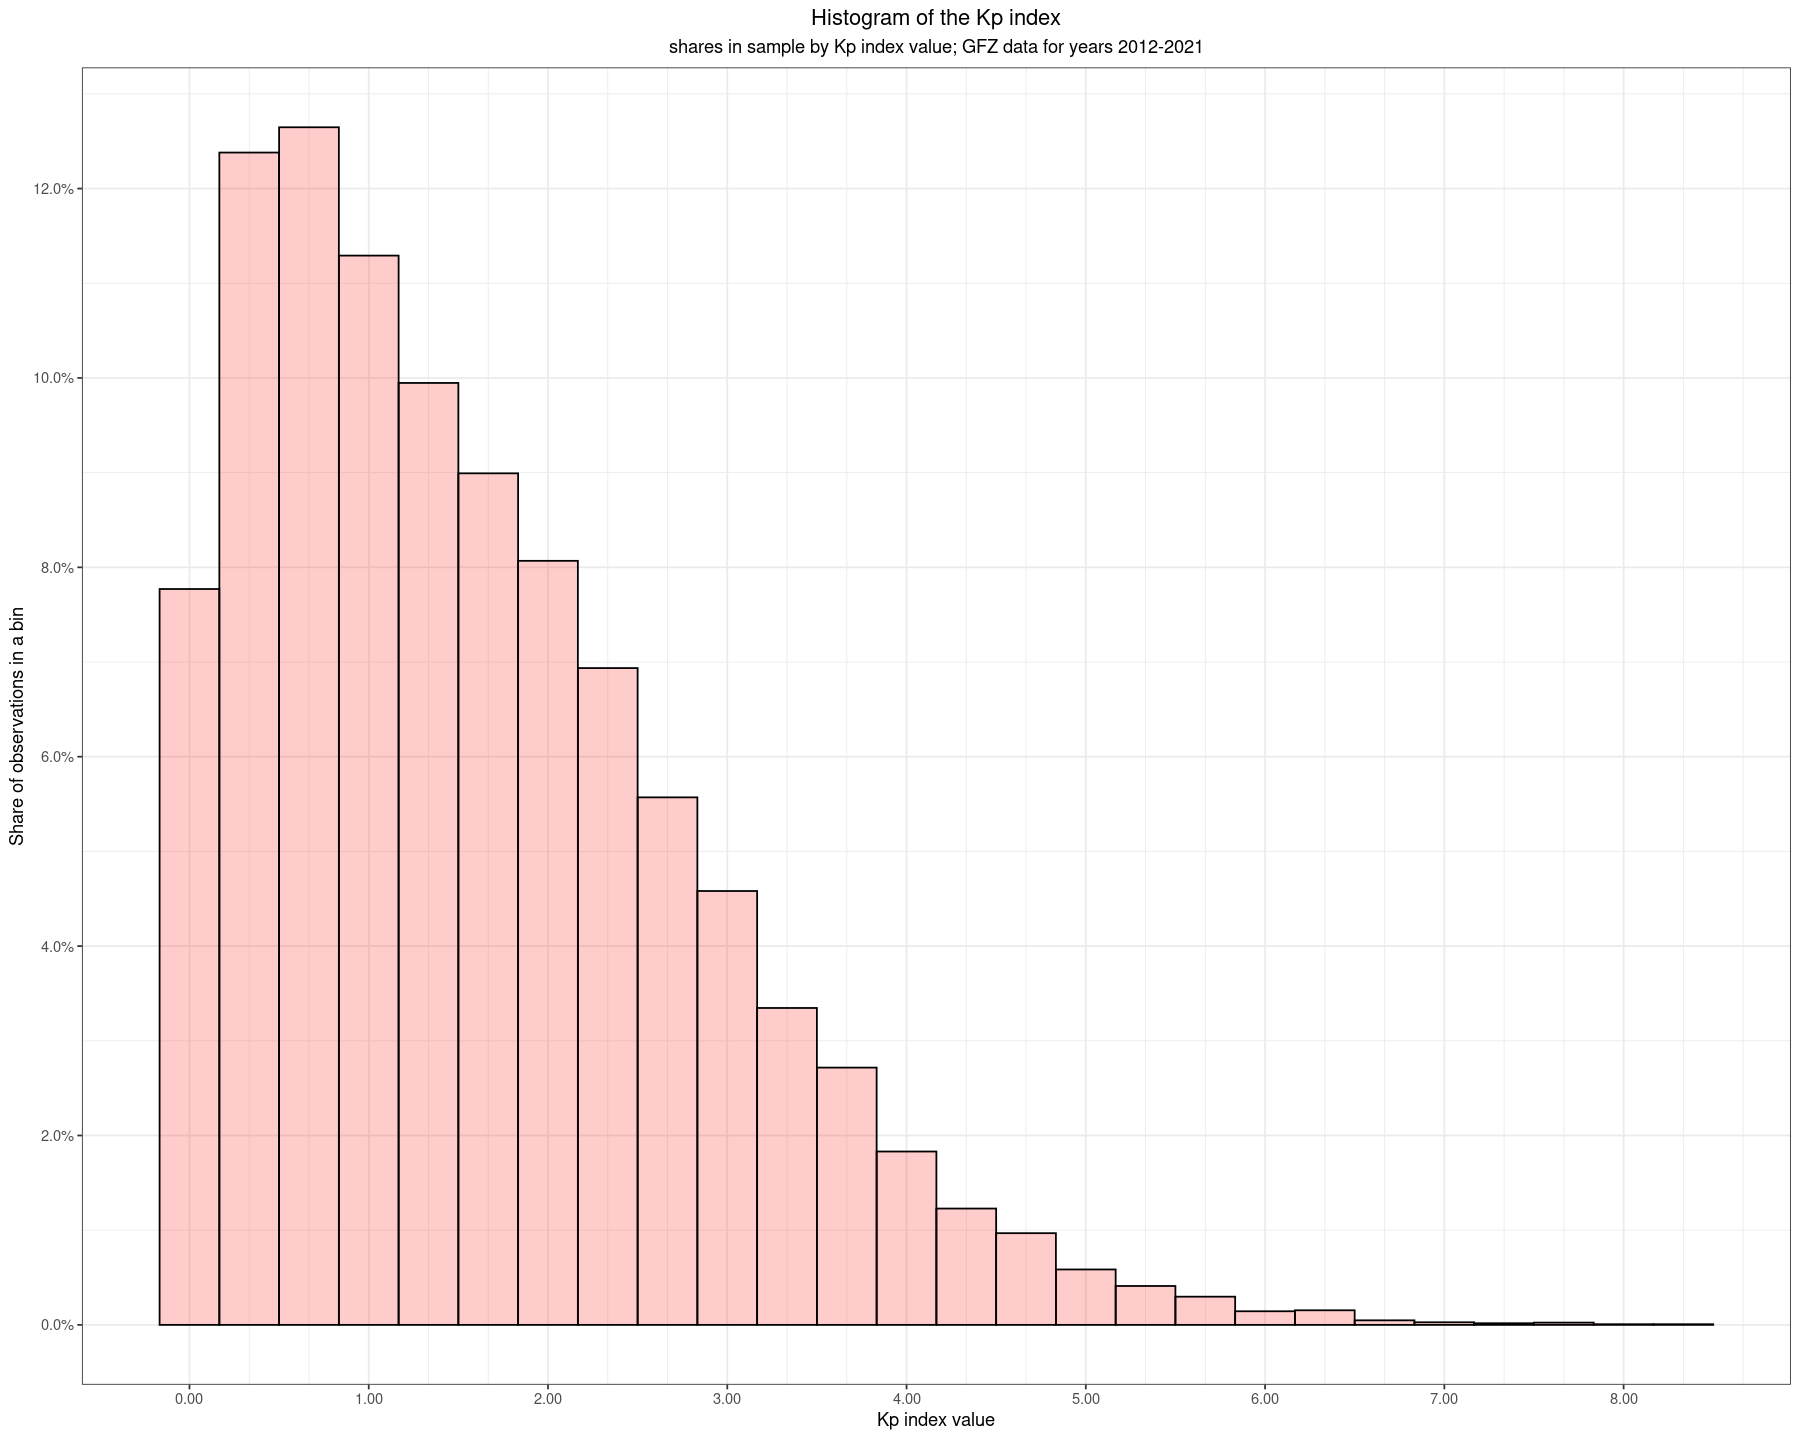

In [49]:
# 9.2. obs shares on the OY axis
options(repr.plot.width=15, repr.plot.height=12)
ggplotKpRelHistogram <- ggplotKpRootHistogram +
  ggplot2::aes(y = ..count.. / sum(..count..)) +
  scale_y_continuous(
    breaks = seq(0, 0.15, 0.02), minor_breaks = seq(0, 0.15, 0.01),
    labels = scales::percent
  )+ ggtitle(label = "Histogram of the Kp index",
             subtitle = "shares in sample by Kp index value; GFZ data for years 2012-2021") +
  theme(
    plot.title = element_text(hjust = 0.5),
    plot.subtitle = element_text(hjust = 0.5)
  ) + ylab(label = "Share of observations in a bin") +
  xlab(label = "Kp index value")
ggplotKpRelHistogram

In [53]:
# --------- 10. estimate gamma distribution parameters for Kp index ---------
# use helper function to fit the non-shifted gamma distribution
dGrid <- seq(min(dtGeomagneticData$Kp), max(dtGeomagneticData$Kp), length.out = 1000)
# 10.1. method of moments fit with zeros removed
lResult <- lFitGammaDistribution(dVec = dtGeomagneticData$Kp, cEstMeth = "MoM",
                                 bRemoveZerosMoM = TRUE)
dAlphaShapeHatMomNoZeros <- lResult$alpha_shape_hat
dBetaRateHatMomNoZeros <- lResult$beta_rate_hat
dGammaMomNoZerosDensity <- dgamma(x = dGrid, shape = dAlphaShapeHatMomNoZeros,
                                  rate = dBetaRateHatMomNoZeros)
# 10.2. method of moments fit with zeros NOT removed
lResult <- lFitGammaDistribution(dVec = dtGeomagneticData$Kp, cEstMeth = "MoM",
                                 bRemoveZerosMoM = FALSE)
dAlphaShapeHatMomZeros <- lResult$alpha_shape_hat
dBetaRateHatMomZeros <- lResult$beta_rate_hat
dGammaMomZerosDensity <- dgamma(x = dGrid, shape = dAlphaShapeHatMomZeros,
                                  rate = dBetaRateHatMomZeros)
# 10.3. maximum likelihood estimates
# 10.3.1. find parameters estimate
lResult <- suppressWarnings(
    lFitGammaDistribution(dVec = dtGeomagneticData$Kp, cEstMeth = "ML")
)
# 10.3.2. plot shape parameter estimate agains the nonlinear euqation solver's
#         starting points
dtEstimatesTable <- lResult$estimates_table
options(repr.plot.width=12, repr.plot.height=8)
plotShapeParamEstimVsStartingPoint <- ggplot2::ggplot(
  data = dtEstimatesTable, mapping = aes(x = starting_point, y = alpha_shape_hat)
) + geom_line() + theme_bw() +
  ggtitle(
    label = "ML shape param estimate against starting point of solver"
  ) +
  theme(plot.title = element_text(hjust = 0.5)) +
  scale_x_continuous(breaks = seq(0, 10, 2),
                     minor_breaks = seq(0, 20, 1))

Warning message in lFitGammaDistribution(dVec = dtGeomagneticData$Kp, cEstMeth = "MoM", :
“Zero values have been found in the dVec argument of the dFitGammaDistribution function and the method of moments estimation method has been indicated and user wants to remove zeros:  removing the zeros from the vector of observations! ”


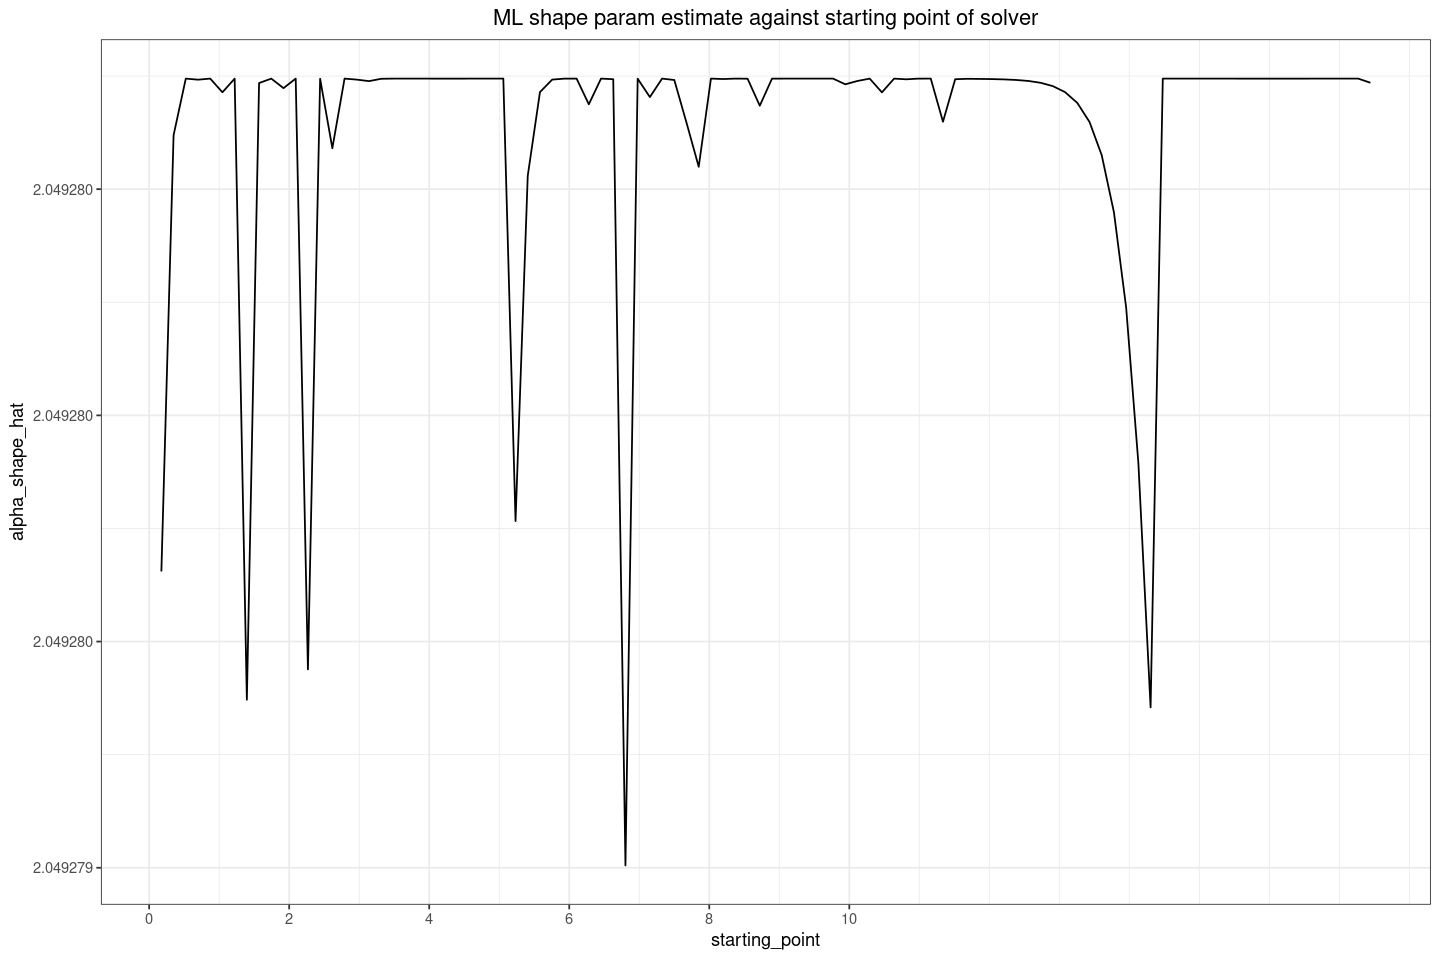

In [54]:
plotShapeParamEstimVsStartingPoint

In [32]:
# load the parameters - given low std of estimates pick the first one - as good
# as any other
dAlphaShapeHatMaxLik <- dtEstimatesTable[1, alpha_shape_hat]
dBetaRateHatMaxLik <- dtEstimatesTable[1, beta_rate_hat]
dGammaMaxLikDensity <- dgamma(x = dGrid, shape = dAlphaShapeHatMaxLik,
                                rate = dBetaRateHatMaxLik)

In [33]:
# 10.4. prepare table with values of estimates
dtEstimatesSummary <- data.table::data.table(
  "Estimation method" = c("MoM, zeros not removed", "MoM, zeros removed", "ML"),
  "Shape parameter estimate" = c(dAlphaShapeHatMomZeros, dAlphaShapeHatMomNoZeros, dAlphaShapeHatMaxLik),
  "Rate parameter estimate" = c(dBetaRateHatMomZeros, dBetaRateHatMomNoZeros, dBetaRateHatMaxLik)
)
View(dtEstimatesSummary)

Estimation method,Shape parameter estimate,Rate parameter estimate
<chr>,<dbl>,<dbl>
"MoM, zeros not removed",1.679273,1.043825
"MoM, zeros removed",2.120854,1.215862
ML,2.049280,1.174829


In [34]:
# 10.5. make plot of densities fitted using various approaches to estimation of parameters
dtDensitiesData <- data.table::data.table(
  grid_point = dGrid,
  mom_no_zeros_density = dGammaMomNoZerosDensity,
  mom_zeros_density = dGammaMomZerosDensity,
  ml_density = dGammaMaxLikDensity
)
dtDensitiesData <- data.table::melt.data.table(
  data = dtDensitiesData,
  id.vars = "grid_point",
  measure.vars = c("mom_no_zeros_density", "mom_zeros_density", "ml_density"),
  variable.name = "which_density",
  value.name = "density_function_value"
)
View(head(dtDensitiesData))

grid_point,which_density,density_function_value
<dbl>,<fct>,<dbl>
0.000000000,mom_no_zeros_density,0.000000000
0.008341341,mom_no_zeros_density,0.006628963
0.016682683,mom_no_zeros_density,0.014270911
0.025024024,mom_no_zeros_density,0.022254595
0.033365365,mom_no_zeros_density,0.030412575
0.041706707,mom_no_zeros_density,0.038660778


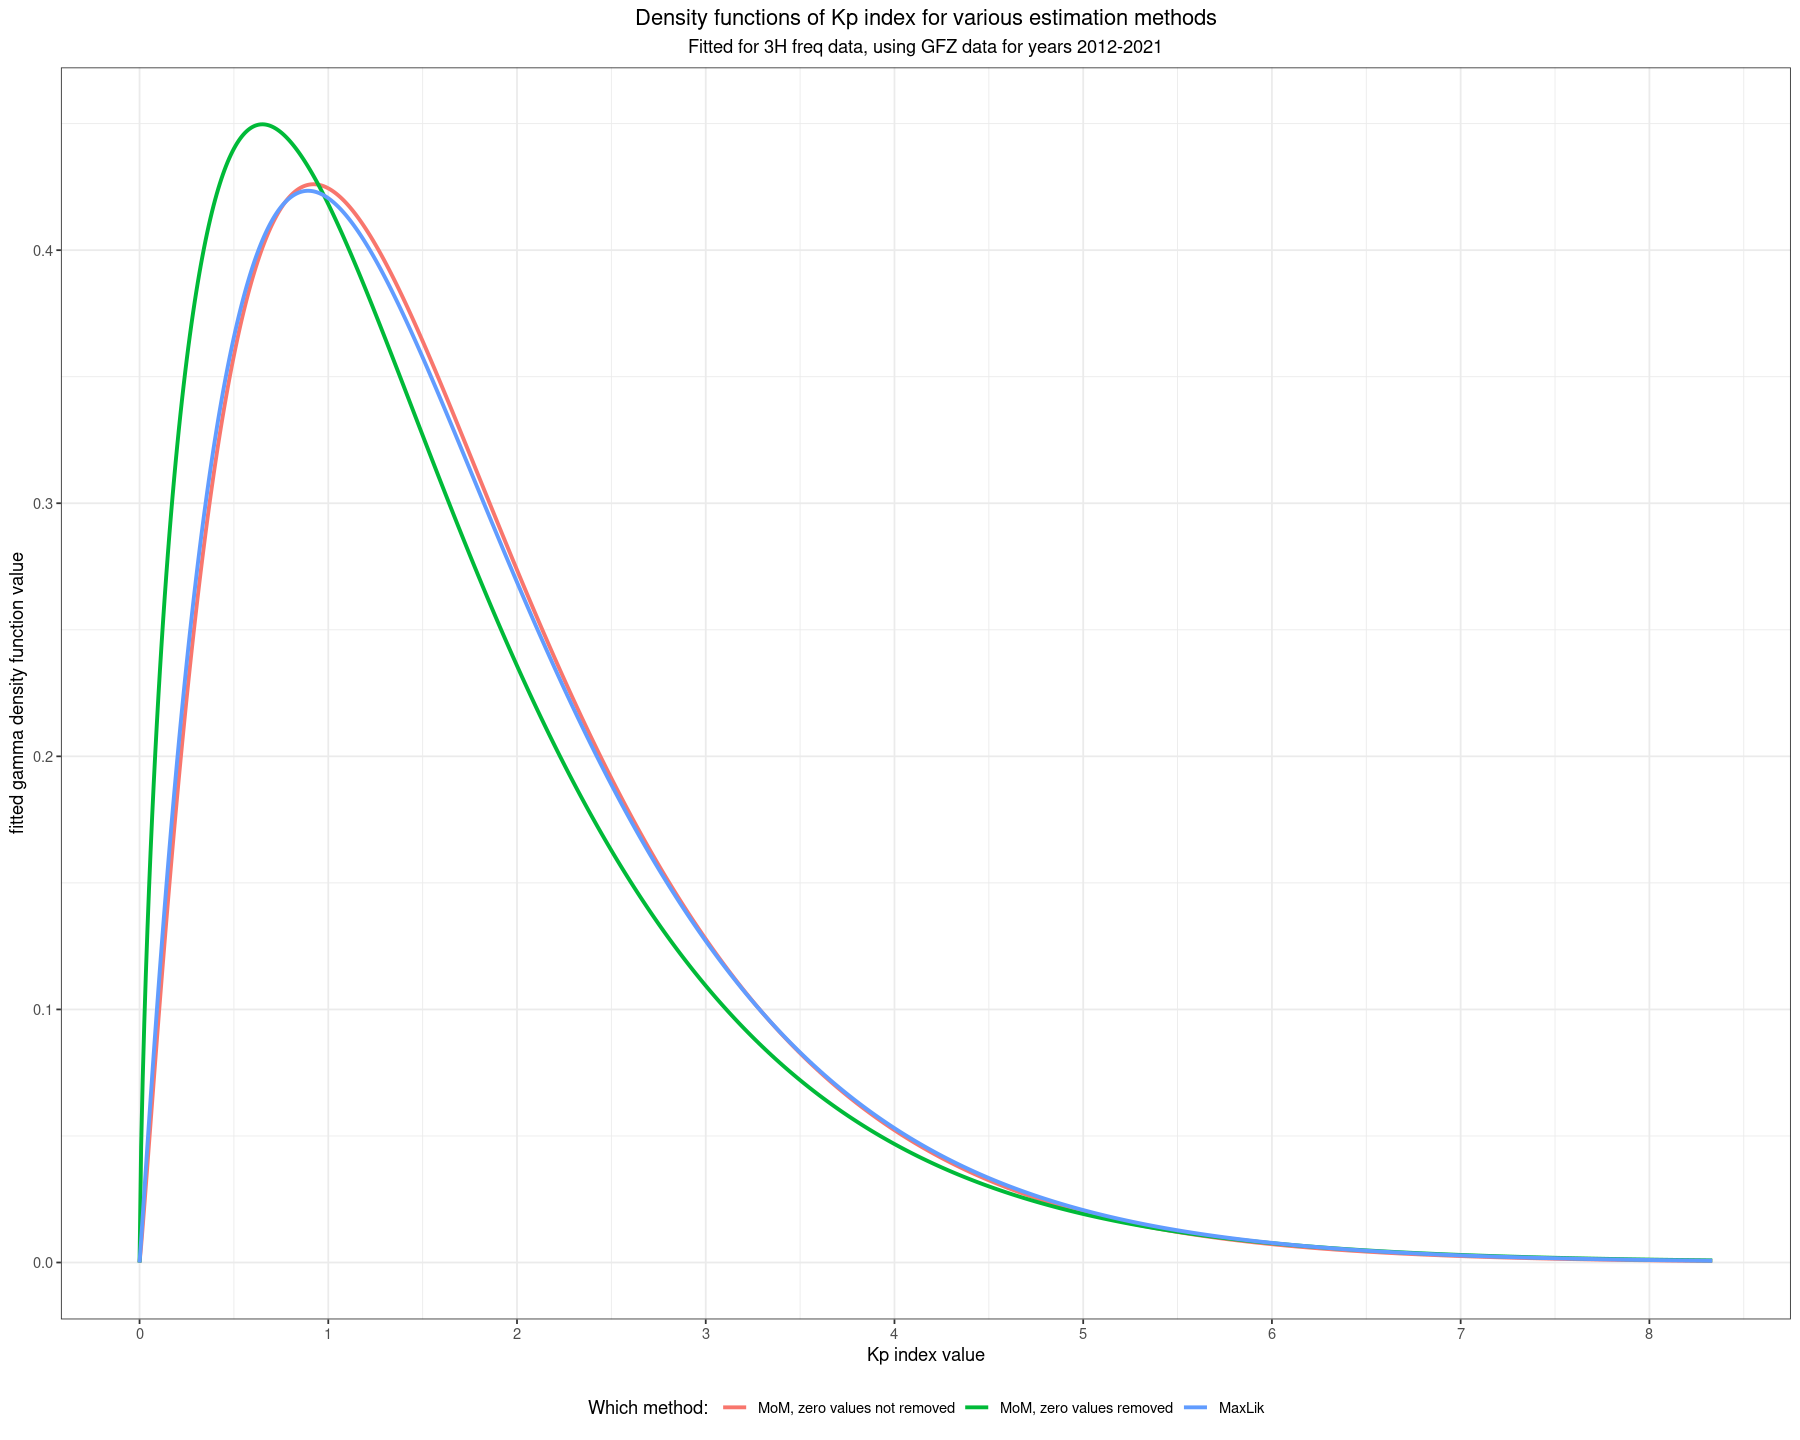

In [56]:
options(repr.plot.width=15, repr.plot.height=12)
ggplotComparativeDensitiesPlot <- ggplot2::ggplot(
  data = dtDensitiesData,
  mapping = aes(x = grid_point, y = density_function_value,
                color = which_density)
) + geom_line(size=1.1) + theme_bw() + theme(legend.position = "bottom") +
  ggtitle(label = "Density functions of Kp index for various estimation methods",
          subtitle = "Fitted for 3H freq data, using GFZ data for years 2012-2021") +
  scale_x_continuous(breaks = seq(0, 9, 1), minor_breaks = seq(0, 9, 0.5)) +
  scale_color_discrete(
    name = "Which method: ",
    labels = c("MoM, zero values not removed", "MoM, zero values removed", "MaxLik")
  ) + theme(plot.title = element_text(hjust=0.5), plot.subtitle = element_text(hjust = 0.5)) +
  xlab(label = "Kp index value") + ylab(label = "fitted gamma density function value")
ggplotComparativeDensitiesPlot

In [36]:
# --------- 10. fit non-linear regression to the ap vs Kp relationship ---------
# 10.1. fitting quadratic relationship: y = a*x^2 + b*x + c
dtRegData <- dtGeomagneticData[, c("Kp", "ap")]
objQuadraticRegModel <- lm(formula = ap ~ Kp + I(Kp^2), data = dtRegData)
# predict(nonlinRegModel)
# 10.2. fitting cubic relationship: y = a*x^2 + b*x + c
objCubicRegModel <- lm(formula = ap ~ Kp + I(Kp^2) + I(Kp^3), data = dtRegData)

In [39]:
# 10.3. compare the results of fitting both regressions
# 10.3.1. quadratic model
broom::glance(objQuadraticRegModel)
broom::augment(objQuadraticRegModel)%>% head() %>% View()
broom::tidy(objQuadraticRegModel)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.9597998,0.959797,2.239593,348832.5,0,2,-65028.7,130065.4,130098.5,146566,29221,29224


ap,Kp,I(Kp^2),.fitted,.resid,.hat,.sigma,.cooksd,.std.resid
<int>,<dbl>,<I<dbl>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,1.667,2.778889,4.680419,1.3195807,5.380791e-05,2.239618,6.227380e-06,0.5892214
4,1.000,1,2.492242,1.5077585,4.392591e-05,2.239614,6.636865e-06,0.6732436
3,0.667,0.444889,2.239095,0.7609048,5.559367e-05,2.239627,2.139315e-06,0.3397608
2,0.333,0.110889,2.546684,-0.5466843,8.998423e-05,2.239629,1.787550e-06,-0.2441108
6,1.667,2.778889,4.680419,1.3195807,5.380791e-05,2.239618,6.227380e-06,0.5892214
6,1.667,2.778889,4.680419,1.3195807,5.380791e-05,2.239618,6.227380e-06,0.5892214


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3.413167,0.028181857,121.1122,0
Kp,-3.441353,0.029141831,-118.0898,0
I(Kp^2),2.520427,0.006154809,409.5054,0


In [40]:
# 10.3.2. cubic model fit
broom::glance(objCubicRegModel)
broom::augment(objCubicRegModel)%>% head() %>% View()
broom::tidy(objCubicRegModel)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.9984079,0.9984078,0.4457024,6108032,0,3,-17849.03,35708.07,35749.48,5804.572,29220,29224


ap,Kp,I(Kp^2),I(Kp^3),.fitted,.resid,.hat,.sigma,.cooksd,.std.resid
<int>,<dbl>,<I<dbl>>,<I<dbl>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,1.667,2.778889,4.632407963,6.230543,-0.23054304,7.087852e-05,0.4457080,4.741659e-06,-0.51727611
4,1.000,1,1,3.981175,0.01882521,5.967540e-05,0.4457100,2.661808e-08,0.04223843
3,0.667,0.444889,0.296740963,2.903029,0.09697080,5.872527e-05,0.4457097,6.950371e-07,0.21757488
2,0.333,0.110889,0.036926037,1.703590,0.29640984,9.503396e-05,0.4457067,1.050985e-05,0.66507140
6,1.667,2.778889,4.632407963,6.230543,-0.23054304,7.087852e-05,0.4457080,4.741659e-06,-0.51727610
6,1.667,2.778889,4.632407963,6.230543,-0.23054304,7.087852e-05,0.4457080,4.741659e-06,-0.51727610


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.2793811,0.006731605,41.5029,0
Kp,4.7299332,0.011307700,418.2931,0
I(Kp^2),-1.5263535,0.004961015,-307.6696,0
I(Kp^3),0.4982139,0.000591860,841.7767,0


In [41]:
# 10.4. make plot of the index with fitted curves:
dtQuadraticFit <- broom::augment(x = objQuadraticRegModel)
dtCubicFit <- broom::augment(x = objCubicRegModel)
dtFittedData <- data.table::data.table(
  Kp = dtQuadraticFit$Kp, ap = dtQuadraticFit$ap,
  quadratic_fit = dtQuadraticFit$.fitted,
  cubic_fit = dtCubicFit$.fitted
) %>% dplyr::mutate(ap = as.double(ap)) %>% as.data.table()

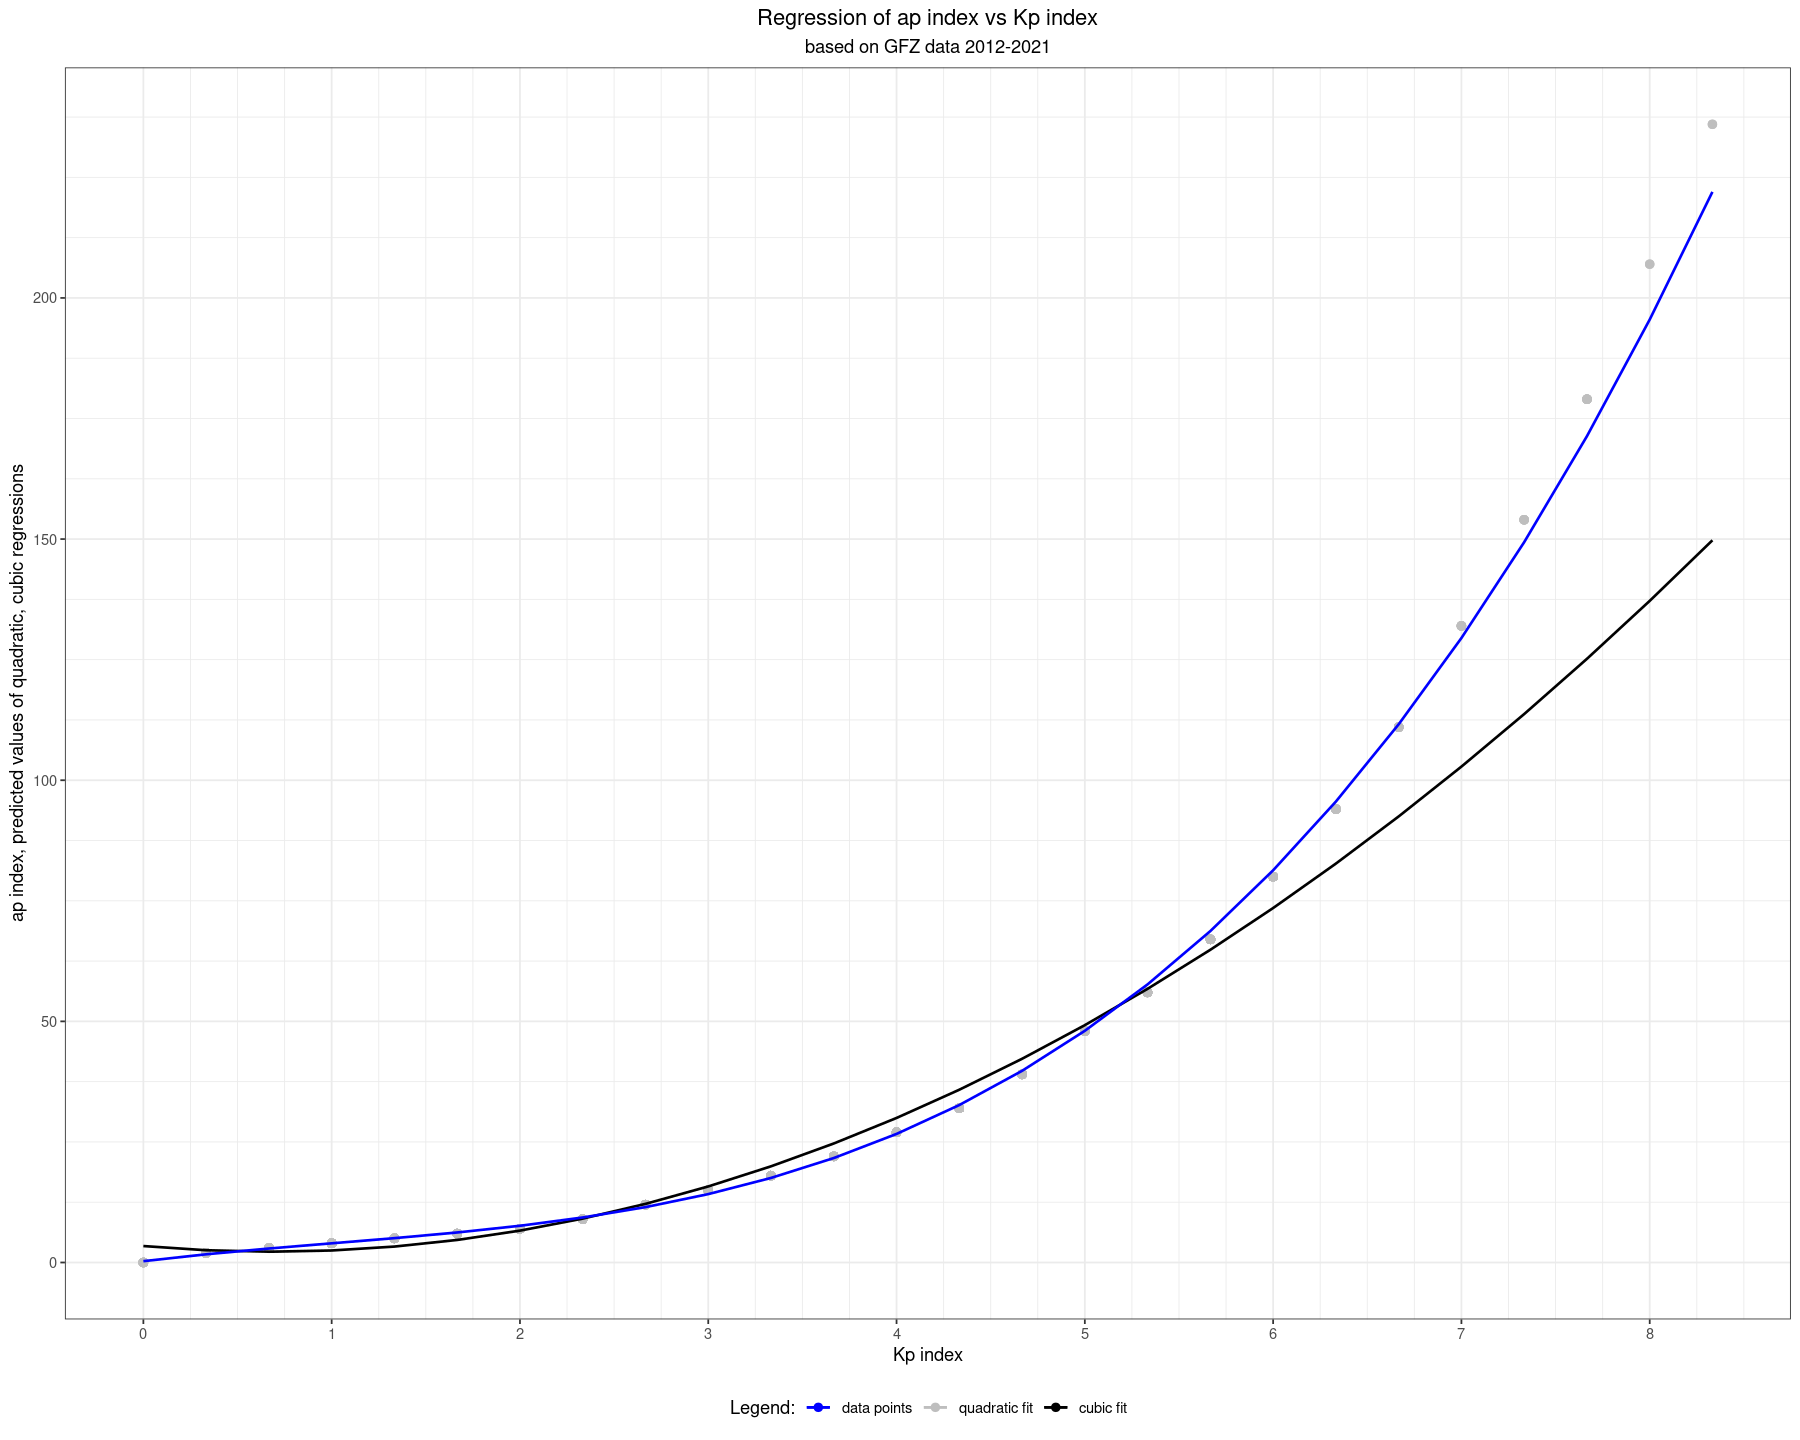

In [57]:
plotNonlinRegsFit <-ggplot(data = dtFittedData) +
  geom_point(mapping = aes(x = Kp, y = ap, color = "blue"),  size = 2, show.legend = T) +
  geom_line(mapping = aes(x = Kp, y = quadratic_fit, color="grey"), size = 0.75, show.legend = T) +
  geom_line(mapping = aes(x = Kp, y = cubic_fit, color="black"), size = 0.75, show.legend = T) +
  theme_bw() +
  scale_x_continuous(breaks = seq(0, 9, 1), minor_breaks = seq(0, 9, 0.25)) +
  scale_y_continuous(breaks = seq(0, 300, 50), minor_breaks = seq(0, 300, 12.5)) +
  scale_color_manual(
    name = "Legend:", guide = "legend",
    values = c("blue", "grey", "black"),
    labels = c("data points", "quadratic fit", "cubic fit")
  ) + ggtitle(
    label = "Regression of ap index vs Kp index",
    subtitle = "based on GFZ data 2012-2021"
  ) + theme(
    legend.position = "bottom",
    plot.title = element_text(hjust = 0.5),
    plot.subtitle = element_text(hjust = 0.5)
  ) + xlab(label = "Kp index") +
  ylab(label = "ap index, predicted values of quadratic, cubic regressions")
plotNonlinRegsFit